### Figures/analyis relating to logit choice functions
Lindsey Gulden, 2025

Partial figures, tables, and analysis for 
[A critical assessment of the IPCC and IEA’s projections for carbon capture and storage](https://docs.google.com/document/d/1mwiSPu30LqLGQT-hkVah-VZzFI5dpKgsWUGA0rdgobI/edit?usp=sharing)

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from scipy.optimize import root_scalar

warnings.filterwarnings("ignore")
%load_ext jupyter_black

## Function definitions, calcs, etc. to use when plotting the price conditions under which the allocation of solar equals the allocation of CCS
bespoke function defined first, then numerical solution finds '1:1' lines; then plots of each figure (figures Figures 6 and S6...where fig 6 is the same data as shown in the middle panel of Figure S6)

In [9]:
def alpha_s_alpha_c(k, q, n, phi, lambda_energy, lambda_fossil):
    numerator = (
        q
        * (n * k) ** lambda_energy
        * (phi * (1 + q) + (1 - phi) * k**lambda_fossil) ** (lambda_energy + 1)
    )
    denominator = (
        k**lambda_fossil
        * (phi * (1 + q) + (1 - phi))
        * (phi * (1 + q) + (1 - phi) * k ** (lambda_fossil + 1)) ** lambda_energy
    )
    return numerator / denominator

## Numerically identify the values for which alpha_solar = alpha_ccs (the 1:1 lines plotted in Figs 6 and S6, the expansion)


In [10]:
# set values of k and values of phi through which we'll iterate
dict_list = []
kvals = [0.5, 0.75, 0.9]
target_value = 1
phivals = [0.4, 0.6, 0.9]
for phinum, phival in enumerate(phivals):
    for k_casenumber, kval in enumerate(kvals):
        for casename, lambda_energy, lambda_fossil in [
            ("default", -3, -10),
            ("midpoint", -5.5, -5.5),
        ]:
            for qval in np.logspace(np.log10(0.1), np.log10(10), 100):

                def funky(x):
                    return (
                        alpha_s_alpha_c(
                            k=kval,
                            q=qval,
                            n=x,
                            phi=phival,
                            lambda_energy=lambda_energy,
                            lambda_fossil=lambda_fossil,
                        )
                        - target_value  # subtracting the target value makes us able to use root seeker for solving
                    )

                # find the roots -- i.e., the solutions
                solution = root_scalar(
                    funky, method="brentq", bracket=[0.1, 100], xtol=1e-8, maxiter=1000
                )
                dict_list.append(
                    # dict_list_phi_mid.append(
                    {
                        "logit_casename": casename,
                        "k_casenumber": k_casenumber,
                        "phinum": phinum,
                        "k": kval,
                        "phi": phival,
                        "lambda_fossil": lambda_fossil,
                        "lambda_energy": lambda_energy,
                        "qval": qval,
                        "s_to_c": target_value,
                        "n": solution.root,
                    }
                )

plot_df = pd.DataFrame(dict_list)

## Figure S6: Conditions under which alpha_solar = alpha_ccs for various ratios of cost of CCS to cost of unabated fossil energy 

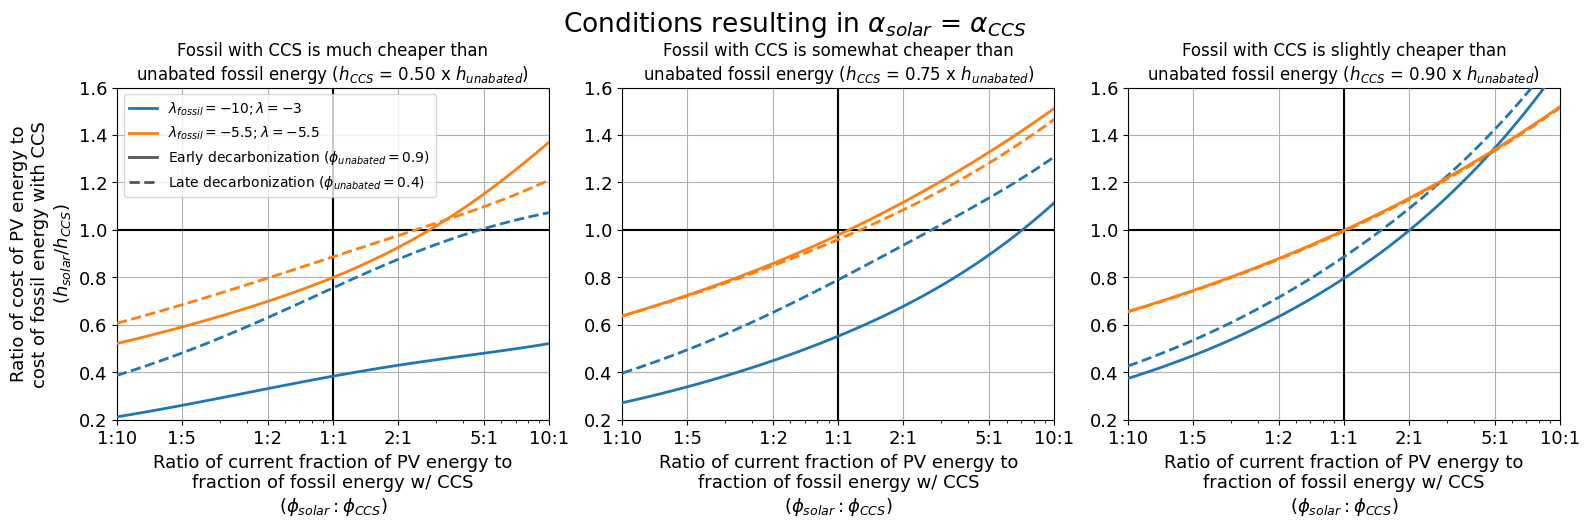

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5.5))

for i, ax in enumerate(axes.reshape(-1)):
    sns.lineplot(
        data=plot_df.loc[(plot_df.k_casenumber == i) & (plot_df.phinum == 0)],
        x="qval",
        y="n",
        hue="logit_casename",
        ax=ax,
        linestyle="--",
        linewidth=2,
        zorder=10,
    )

    sns.lineplot(
        data=plot_df.loc[(plot_df.k_casenumber == i) & (plot_df.phinum == 2)],
        x="qval",
        y="n",
        hue="logit_casename",
        ax=ax,
        linestyle="-",
        linewidth=2,
        zorder=10,
    )

    ax.get_legend().remove()
    ax.set_xscale("log")
    if i == 0:
        ax.set_ylabel(
            "Ratio of cost of PV energy to\ncost of fossil energy with CCS\n("
            + r"$h_{solar}/h_{CCS}$"
            + ")",
            fontsize=13,
        )
    else:
        ax.set_ylabel("")
    ax.set_xlabel(
        "Ratio of current fraction of PV energy to\nfraction of fossil energy w/ CCS\n("
        + r"$\phi_{solar}:\phi_{CCS}$"
        + ")",
        fontsize=13,
    )
    ax.set_ylim([0.2, 1.6])
    ax.set_xlim([1 / 10, 10])
    ax.grid(zorder=-1)
    ax.set_xticks(
        [0.1, 0.2, 0.5, 1, 2, 5, 10],
        labels=["1:10", "1:5", "1:2", "1:1", "2:1", "5:1", "10:1"],
        fontsize=13,
    )
    ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=13)

    ax.plot([1, 1], [0, 1.6], "k", zorder=3)  # dashes=[10, 2, 2, 2],
    ax.plot([1 / 10, 10], [1, 1], "k", zorder=3)  # dashes=[10, 2, 2, 2],


legend_handles = [
    Line2D(
        [0, 1],
        [0, 1],
        color="tab:blue",
        linewidth=2,
        label=r"$\lambda_{fossil}=" + "-10; $" + r"$\lambda=" + "-3$",
    ),
    Line2D(
        [0, 1],
        [0, 1],
        color="tab:orange",
        linewidth=2,
        label=r"$\lambda_{fossil}=" + "-5.5; $" + r"$\lambda=" + "-5.5$",
    ),
    Line2D(
        [0, 1],
        [0, 1],
        color="#555555",
        linestyle="-",
        linewidth=2,
        label="Early decarbonization (" + r"$\phi_{unabated}=" + f"{phivals[2]:.1f})$",
    ),
    Line2D(
        [0, 1],
        [0, 1],
        color="#555555",
        linestyle="--",
        linewidth=2,
        label="Late decarbonization (" + r"$\phi_{unabated}=" + f"{phivals[0]:.1f})$",
    ),
]
axes[0].legend(handles=legend_handles, loc="upper left")
axes[0].set_title(
    "Fossil with CCS is much cheaper than\nunabated fossil energy ("
    + r"$h$"
    + "$_{CCS}$"
    + f" = {kvals[0]:.2f} x "
    r"$h$" + "$_{unabated}$" + ")"
)
axes[1].set_title(
    "Fossil with CCS is somewhat cheaper than\nunabated fossil energy ("
    + r"$h$"
    + "$_{CCS}$"
    + f" = {kvals[1]:.2f} x "
    r"$h$" + "$_{unabated}$" + ")"
)
axes[2].set_title(
    "Fossil with CCS is slightly cheaper than\nunabated fossil energy ("
    + r"$h$"
    + "$_{CCS}$"
    + f" = {kvals[2]:.2f} x "
    r"$h$" + "$_{unabated}$" + ")",
    fontsize=12,
)
fig.suptitle(
    "Conditions resulting in " + r"$\alpha$" + "$_{solar}$" + " = "
    r"$\alpha$" + "$_{CCS}$",
    y=0.95,
    fontsize=19,
)
fig.tight_layout()
fig.savefig("fig_s6.png")
fig.savefig("fig_s6.pdf")

## Figure 6: Conditions under which alpha_solar = alpha_ccs for ratios of cost when cost of CCS is 75% of the cost of unabated fossil energy 
* Figure 6 is the same data as in the middle panel of Figure S6 (which shows the same results with different ratios between h_ccs and h_unabated)

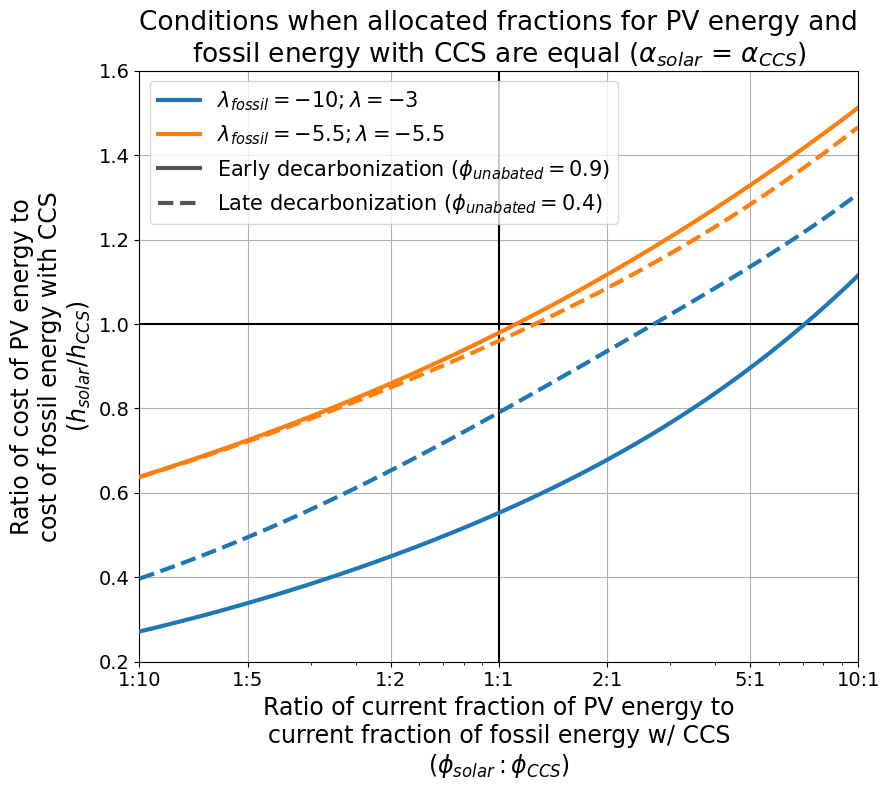

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))

sns.lineplot(
    data=plot_df.loc[(plot_df.k_casenumber == 1) & (plot_df.phinum == 0)],
    x="qval",
    y="n",
    hue="logit_casename",
    ax=ax,
    linestyle="--",
    linewidth=3,
    zorder=10,
)

sns.lineplot(
    data=plot_df.loc[(plot_df.k_casenumber == 1) & (plot_df.phinum == 2)],
    x="qval",
    y="n",
    hue="logit_casename",
    ax=ax,
    linestyle="-",
    linewidth=3,
    zorder=10,
)

ax.get_legend().remove()
ax.set_xscale("log")

ax.set_ylabel(
    "Ratio of cost of PV energy to\ncost of fossil energy with CCS\n("
    + r"$h_{solar}/h_{CCS}$"
    + ")",
    fontsize=17,
)

ax.set_xlabel(
    "Ratio of current fraction of PV energy to\ncurrent fraction of fossil energy w/ CCS\n("
    + r"$\phi_{solar}:\phi_{CCS}$"
    + ")",
    fontsize=17,
)
ax.set_ylim([0.2, 1.6])
ax.set_xlim([1 / 10, 10])
ax.grid(zorder=-1)
ax.set_xticks(
    [0.1, 0.2, 0.5, 1, 2, 5, 10],
    labels=["1:10", "1:5", "1:2", "1:1", "2:1", "5:1", "10:1"],
    fontsize=14,
)
# ax.set_xticklabels(["", "1:10", "1:1", "10:1"], fontsize=14)
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=14)

ax.plot([1, 1], [0, 1.6], "k", zorder=3)  # dashes=[10, 2, 2, 2],
ax.plot([1 / 10, 10], [1, 1], "k", zorder=3)  # dashes=[10, 2, 2, 2],


legend_handles = [
    Line2D(
        [0, 1],
        [0, 1],
        color="tab:blue",
        linewidth=3,
        label=r"$\lambda_{fossil}=" + "-10; $" + r"$\lambda=" + "-3$",
    ),
    Line2D(
        [0, 1],
        [0, 1],
        color="tab:orange",
        linewidth=3,
        label=r"$\lambda_{fossil}=" + "-5.5; $" + r"$\lambda=" + "-5.5$",
    ),
    Line2D(
        [0, 1],
        [0, 1],
        color="#555555",
        linestyle="-",
        linewidth=3,
        label="Early decarbonization (" + r"$\phi_{unabated}=" + f"{phivals[2]:.1f})$",
    ),
    Line2D(
        [0, 1],
        [0, 1],
        color="#555555",
        linestyle="--",
        linewidth=3,
        label="Late decarbonization (" + r"$\phi_{unabated}=" + f"{phivals[0]:.1f})$",
    ),
]
ax.legend(handles=legend_handles, loc="upper left", fontsize=15)
ax.set_title(
    "Conditions when allocated fractions for PV energy and\nfossil energy with CCS are equal ("
    + r"$\alpha$"
    + "$_{solar}$"
    + " = "
    r"$\alpha$" + "$_{CCS}$" + ")",
    # "\n(" + r"$h$" + "$_{CCS}$" + " = 0.8 x "
    # r"$h$" + "$_{unabated}$" + ")",
    fontsize=19,
)

fig.tight_layout()
fig.savefig("fig_6.png")
fig.savefig("fig_6.pdf")

## Figure S5 show ratio of solar to CCS under several simplifying assumptions
* Note that this is a 'single-level' logit-choice funciton (not the multilevel verison elsewhere in this notebook). 
* Figure is used to explain how the logit weights between current share and price

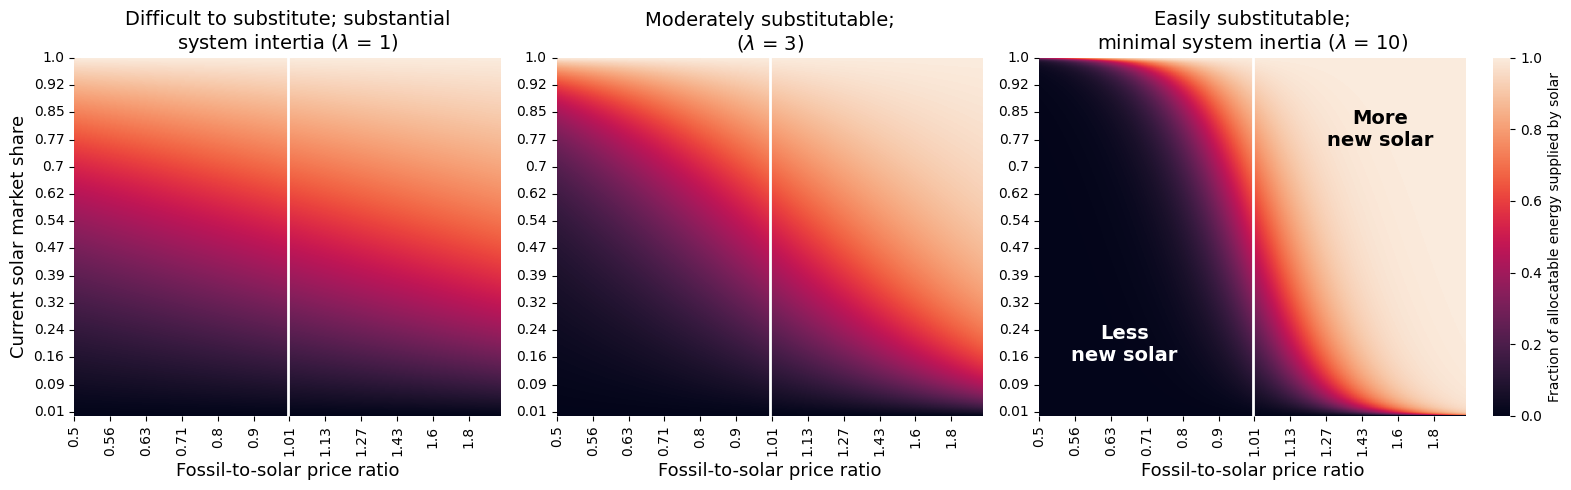

In [13]:
# define the function to plot a heatmap for. Rewrite of the logit function where x is
def logit_reduced(x, y, lam):
    denom = x + y**lam - x * y**lam
    return x / denom


# prep the mesh grid
npoints = 1000

x = np.linspace(0, 1, num=npoints)
y = np.logspace(np.log10(0.5), np.log10(2), num=npoints)
mesh_df = pd.DataFrame(
    np.reshape(np.meshgrid(x, y), newshape=[2, npoints * npoints]).T, columns=["x", "y"]
)
mesh_df["x_ticks"] = [round(v, int(np.log10(npoints)) + 1) for v in mesh_df["x"]]
mesh_df["y_ticks"] = [round(v, int(np.log10(npoints)) + 1) for v in mesh_df["y"]]

# plot different lambda values
fig, axes = plt.subplots(1, 3, figsize=(16, 5), width_ratios=[1, 1, 1.25])

titles = [
    "Difficult to substitute; substantial\nsystem intertia (" + r"$\lambda$" + " = 1)",
    "Moderately substitutable;\n(" + r"$\lambda$" + " = 3)",
    "Easily substitutable;\nminimal system inertia (" + r"$\lambda$" + " = 10)",
]

for i, lam in enumerate([-1, -3, -10]):
    ax = axes[i]

    # Compute f_lambda
    mesh_df["f_lambda"] = [
        logit_reduced(xx, yy, lam) for xx, yy in zip(mesh_df["x"], mesh_df["y"])
    ]

    # Pivot for heatmap
    plot_df = mesh_df[["x_ticks", "y_ticks", "f_lambda"]].pivot(
        index="x_ticks", columns="y_ticks", values="f_lambda"
    )
    plot_df.sort_values(by="x_ticks", ascending=False, inplace=True)

    # Only add colorbar for the last subplot
    cbar = i == 2
    sns.heatmap(
        plot_df,
        ax=ax,
        cbar=cbar,
        cbar_kws={"label": "Fraction of allocatable energy supplied by solar"}
        if cbar
        else None,
    )

    # Title and labels
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel(
        "Fossil-to-solar price ratio",
        fontsize=13,
    )
    if i == 0:
        ax.set_ylabel("Current solar market share", fontsize=13)
    else:
        ax.set_ylabel("")
    # Show tick labels only every other tick
    # x axis
    xticks = ax.get_xticks()
    xlabels = ax.get_xticklabels()
    ax.set_xticks(xticks[::2])
    ax.set_xticklabels(
        [str(round(float(lbl.get_text()), 2)) for lbl in xlabels[::2]], rotation=90
    )

    # y axis
    yticks = ax.get_yticks()
    ylabels = ax.get_yticklabels()
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels([str(round(float(lbl.get_text()), 2)) for lbl in ylabels[::2]])

    # ---- Add a single white vertical line at x=1 ----
    x_idx = np.argmin(np.abs(plot_df.columns.values - 1))
    ax.axvline(x=x_idx + 0.5, color="white", linewidth=2)  # +0.5 to center line on cell

    # ---- Add "More new solar" text box in upper right quadrant ----
    if i == 2:
        ax.text(
            0.8,
            0.8,  # x, y in axis fraction coordinates (top-right quadrant)
            "More\nnew solar",
            color="black",
            fontsize=14,
            fontweight="bold",
            ha="center",
            va="center",
            transform=ax.transAxes,  # relative to axes
            bbox=dict(
                facecolor="none", alpha=1, edgecolor="none"
            ),  # optional background
        )
        ax.text(
            0.2,
            0.2,  # x, y in axis fraction coordinates (top-right quadrant)
            "Less\nnew solar",
            color="white",
            fontsize=14,
            fontweight="bold",
            ha="center",
            va="center",
            transform=ax.transAxes,  # relative to axes
            bbox=dict(
                facecolor="none", alpha=1, edgecolor="none"
            ),  # optional background
        )

fig.tight_layout()
fig.savefig("fig_s5.png")
fig.savefig("fig_s5.pdf")

## Additional figure not included in paper but damn interesting :-P

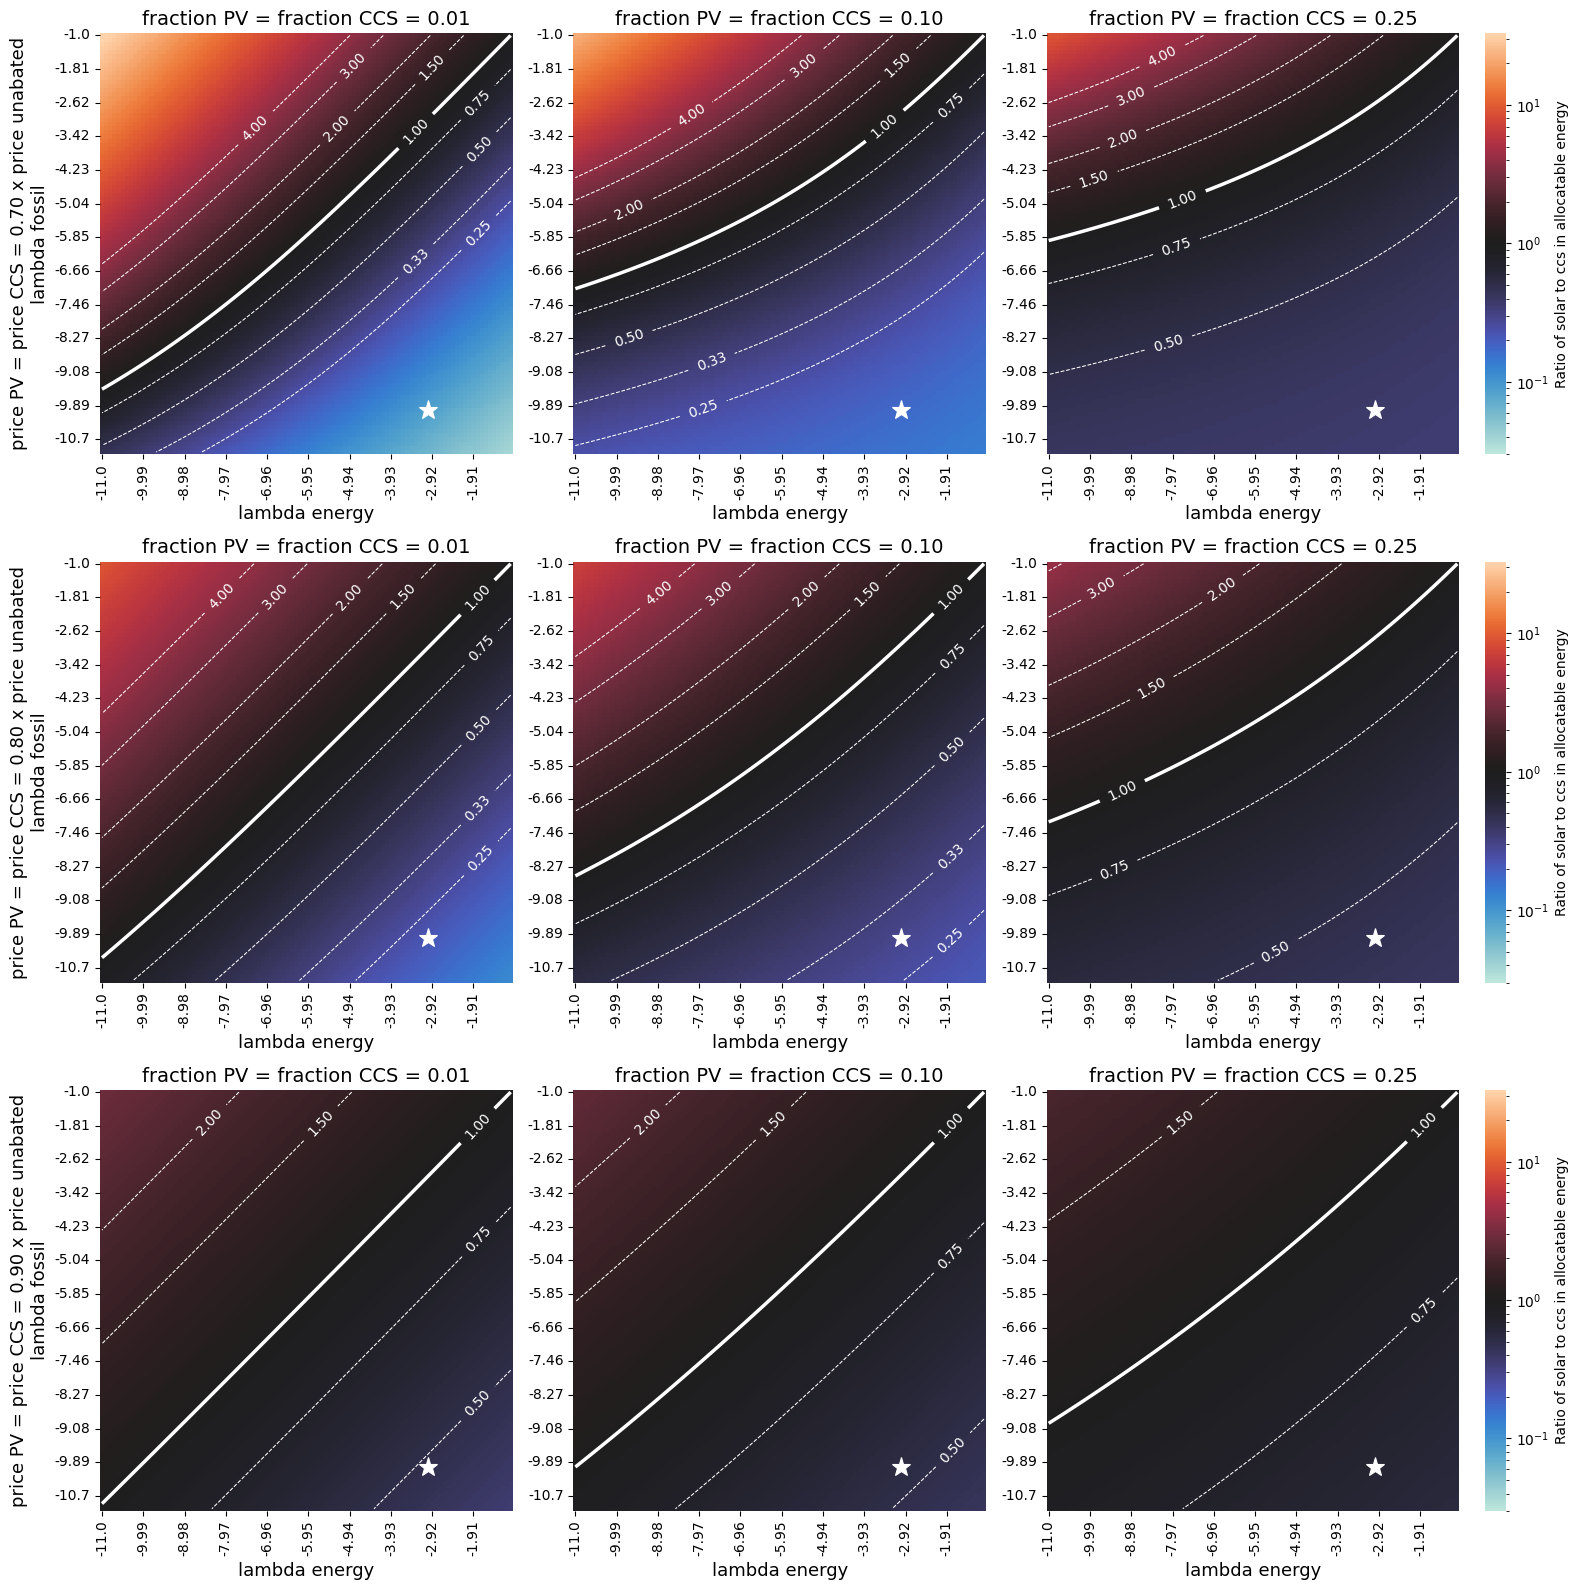

In [8]:
def solar_to_ccs(theta, m, lambda_energy, lambda_fossil):
    """returns ratio of solar to CCS from a simplified modified logit function under a few simplifying assumptions"""
    if (theta < 0) | (theta > 1):
        raise ValueError
    numerator = (m**lambda_energy) * (theta * m**lambda_fossil - 2 * theta + 1) ** (
        lambda_energy + 1
    )
    denominator = (
        (m**lambda_fossil)
        * (1 - theta)
        * (theta * m ** (lambda_fossil + 1) - 2 * theta + 1) ** lambda_energy
    )
    return numerator / denominator


# prep the mesh grid
npoints = 100

x_lambda_energy = np.linspace(-11, -1, num=npoints)
y_lambda_fossil = np.linspace(-11, -1, num=npoints)

# y = np.logspace(np.log10(0.5), np.log10(2), num=npoints)
mesh_df = pd.DataFrame(
    np.reshape(
        np.meshgrid(x_lambda_energy, y_lambda_fossil), newshape=[2, npoints * npoints]
    ).T,
    columns=["x_lambda_energy", "y_lambda_fossil"],
)
mesh_df["x_lambda_energy_ticks"] = [
    round(v, int(np.log10(npoints)) + 1) for v in mesh_df["x_lambda_energy"]
]
mesh_df["y_lambda_fossil_ticks"] = [
    round(v, int(np.log10(npoints)) + 1) for v in mesh_df["y_lambda_fossil"]
]

# plot different lambda values
fig, axes = plt.subplots(3, 3, figsize=(16, 16), width_ratios=[1, 1, 1.25])
norm = LogNorm(vmin=0.03, vmax=33)

for i, theta in enumerate([0.01, 0.1, 0.25]):
    for j, m in enumerate([0.7, 0.8, 0.9]):
        ax = axes[j][i]

        # Compute s_to_c
        mesh_df["s_to_c"] = [
            solar_to_ccs(theta, m, lambda_energy, lambda_fossil)
            for lambda_energy, lambda_fossil in zip(
                mesh_df["x_lambda_energy"], mesh_df["y_lambda_fossil"]
            )
        ]

        # Pivot for heatmap
        plot_df = (
            mesh_df[["x_lambda_energy_ticks", "y_lambda_fossil_ticks", "s_to_c"]]
            .pivot(
                index="y_lambda_fossil_ticks",
                columns="x_lambda_energy_ticks",
                values="s_to_c",
            )
            .copy()
        )
        # display(plot_df.head())
        plot_df.sort_values(by="y_lambda_fossil_ticks", ascending=False, inplace=True)

        # Only add colorbar for the last subplot
        cbar = i == 2
        sns.heatmap(
            plot_df,
            ax=ax,
            norm=norm,
            cbar=cbar,
            cmap="icefire",  # sns.diverginh_palette(35, 145, s=100, center="dark", as_cmap=True),
            cbar_kws={"label": "Ratio of solar to ccs in allocatable energy"}
            if cbar
            else None,
        )
        # ---- Add white contour where s_to_c == 1 ----
        Z = plot_df.values

        ny, nx = Z.shape
        X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

        cs = ax.contour(
            X + 0.5,
            Y + 0.5,
            Z,
            levels=[0.25, 0.33, 0.5, 0.75, 1, 1.5, 2, 3, 4],
            colors="white",
            linewidths=[0.75, 0.75, 0.75, 0.75, 2.5, 0.75, 0.75, 0.75, 0.75],
            linestyles=["--", "--", "--", "--", "-", "--", "--", "--", "--"],
        )
        ax.clabel(cs, inline=True, fontsize=10)  # label contour lines

        # ---- Add white star at (lambda_energy = -3, lambda_fossil = -10) ----
        x_target = -3
        y_target = -10

        # find nearest column and row indices
        x_idx = np.argmin(np.abs(plot_df.columns.values - x_target))
        y_idx = np.argmin(np.abs(plot_df.index.values - y_target))

        # plot star at center of the heatmap cell
        ax.plot(
            x_idx + 0.5,
            y_idx + 0.5,
            marker="*",
            color="white",
            markersize=14,
            markeredgecolor="white",
            markeredgewidth=0.8,
            zorder=10,
        )

        # Title and labels
        ax.set_title(f"fraction PV = fraction CCS = {theta:.02f}", fontsize=14)
        ax.set_xlabel(
            "lambda energy",
            fontsize=13,
        )
        if i == 0:
            ax.set_ylabel(
                f"price PV = price CCS = {m:.02f} x price unabated\nlambda fossil",
                fontsize=13,
            )
        else:
            ax.set_ylabel("")
        # Show tick labels only every other tick
        # x axis
        xticks = ax.get_xticks()
        xlabels = ax.get_xticklabels()
        ax.set_xticks(xticks[::2])
        ax.set_xticklabels(
            [str(round(float(lbl.get_text()), 2)) for lbl in xlabels[::2]], rotation=90
        )

        # y axis
        yticks = ax.get_yticks()
        ylabels = ax.get_yticklabels()
        ax.set_yticks(yticks[::2])
        ax.set_yticklabels(
            [str(round(float(lbl.get_text()), 2)) for lbl in ylabels[::2]]
        )


fig.tight_layout()
fig.savefig("solar_to_ccs.png")